In [1]:
import pandas as pd
import re
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Easy + Medium

**Dataset**:

Each code in the dataset is taken from GitHub.

Since code from GitHub differs from that of Telegram, I divided each file into many sequences (shorter code is more occasional in TG).

Each non-code (English text) is a fragment from the book Harry Potter Part 1.

**Preprocessing**

I used CountVectorizer with no preliminary preprocessing (except for deleting non-ASCII symbols) because stop words and punctuation matter in this task.

Lemmatization didn't bring noticeable improvement, which is understandable because words in the code aren't diverse.

**Models**:

Random forest showed worse results compared to Logistic Regression.

CatBoost terminated my kernel.

**Metrics**:

I decided to use the F1 score for multi-class classification (weighted and macro) because the data is imbalanced.

Finally, I tested my model on the chats from TG.

In [2]:
df_code = pd.read_csv('data/code_snippets.csv')
df_code = df_code.rename(columns={"content": "text", "type": "lang"})
df_code['lang'] = df_code['lang'].astype(str)

In [3]:
langs = [
        "py",
        "cpp",
        "js",
        "java",
        "yaml",
        "sh",
        "md",
        "c",
        "kt",
        "hs",
        "other"
        ]

In [4]:
mapping = {
        "py": 1,
        "cpp": 2,
        "js": 3,
        "java": 4,
        "yaml": 5,
        "sh": 6,
        "md": 7,
        "c": 8,
        "kt": 9,
        "hs": 10,
        "other": 11
}

In [5]:
df_code = df_code[df_code['lang'].isin(langs)]

## Split each code into many sequences

In [6]:

split_rows = []

for index, row in df_code.iterrows():
    lang = row['lang']
    text = row['text']
    split_texts = [text[i:i + 80] for i in range(0, len(text), 80)]
    for split_text in split_texts:
        split_rows.append({'lang': lang, 'text': split_text})
    
df_code = pd.DataFrame(split_rows)

## Add simple English text

In [7]:
# CREATE ENGLISH TEXT (OTHER) SAMPLES FROM A BOOK (.txt file)

with open('data/english_text.txt', 'r', encoding='utf-8') as file:
    text = file.read()


split_texts = []
start_index = 0
while start_index < len(text):
    end_index = start_index + 80
    if end_index > len(text):
        end_index = len(text)
    split_texts.append(text[start_index:end_index])
    start_index = end_index

split_texts = [s for s in split_texts if s]

data = {'lang': ['other'] * len(split_texts), 'text': split_texts}
df_eng_text = pd.DataFrame(data)


In [8]:
df = pd.concat([df_code, df_eng_text])
df["lang"] = df["lang"].map(mapping)

## Delete odd symbols

In [9]:
df = df[df['text'].apply(lambda x: all(ord(c) < 128 for c in x))]
df.reset_index(drop=True, inplace=True)

## Train model

In [10]:
train, test = train_test_split(df, random_state=239)
bow = CountVectorizer()

x_train = bow.fit_transform(train["text"])
x_test = bow.transform(test["text"])
y_train = train["lang"]

In [11]:
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

## Predictions & metrics

In [12]:
y_test = test["lang"]
y_pred = model.predict(x_test)

In [13]:
def print_metrics(y_pred, y_test):
    print(f"f1 weighted {round(f1_score(y_pred, y_test, average="weighted"), 3)}")
    print(f"f1 micro {round(f1_score(y_pred, y_test, average="micro"), 3)}")

In [14]:
print_metrics(y_pred, y_test)

f1 weighted 0.808
f1 micro 0.803


In [15]:
from sklearn.metrics import confusion_matrix

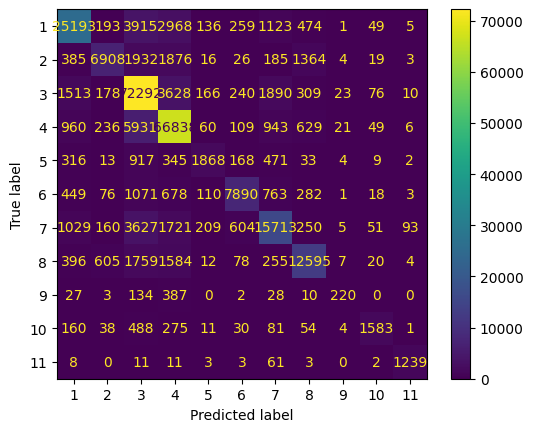

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

plt.show()

Conclusions are obvious: similiar (in terms of syntax) languages are often misclassified (i.e. python and js)

## Save model

In [17]:
with open("model.pkl", 'wb') as file:
    pickle.dump((model, bow), file)

# Tests on real chats

I downloaded history of 10 telegram chats in JSON format.

For YAML and MARKDOWN I asked ChatGPT to generate human like code with errors.

I named them ```py.json```, ```cpp.json``` etc.

From each chat I extracted code snippets.

In [18]:
files = [file for file in os.listdir("data") if file.endswith(".json")]

In [19]:
def create_df_from_json_history(filepath: str) -> pd.DataFrame:
    data = pd.read_json(f"data/{filepath}")
    codes = []
    LANG = filepath[0:-5]
    for index, row in data.iterrows():
        messages = row.messages["text_entities"]
        for message in messages:
            if message['type'] == 'pre' and message['text']:
                codes.append(message['text'])

    temp_data = {'text': codes, 'lang': [mapping[LANG]] * len(codes)}
    return pd.DataFrame(temp_data)

In [20]:
dataframes = []
for file in files:
    dataframes.append(create_df_from_json_history(filepath=file))

df_test = pd.concat(dataframes)

In [21]:
x_test_python = bow.transform(df_test["text"])
y_test_py = df_test["lang"]
y_pred_py = model.predict(x_test_python)

print_metrics(y_pred_py, y_test_py)

f1 weighted 0.309
f1 micro 0.437


### The metrics are worse, which is clear.